In [1]:
import warnings
warnings.filterwarnings("ignore")

## Research large moves in the futures markets

In [2]:

import zipfile
import glob
import pandas as pd
import numpy as np

from argparse import ArgumentParser
from argparse import RawDescriptionHelpFormatter
import sys
import os
if  not './' in sys.path:
    sys.path.append('./')
if  not '../' in sys.path:
    sys.path.append('../')

from barchartacs import build_db
from barchartacs import db_info
import plotly.graph_objs as go
from plotly.offline import  init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.tools as tls
from plotly.graph_objs.layout import Font,Margin
from IPython import display

import datetime
import io
from tqdm import tqdm,tqdm_notebook
from barchartacs import pg_pandas as pg
import mibian
import py_vollib
import importlib
from py_vollib import black
from py_vollib.black import implied_volatility
import ipdb
import traceback
import pandas_datareader.data as pdr
from dashapp import dashapp2 as dashapp
import dash_html_components as html
import dash_core_components as dcc
from itertools import accumulate 


importlib.reload(dashapp)

<module 'dashapp.dashapp2' from '/Users/bperlman1/Documents/billybyte/pyliverisk/dashapp/dashapp/dashapp2.py'>

In [3]:
from pandas.tseries.holiday import USFederalHolidayCalendar
bday_us = pd.offsets.CustomBusinessDay(calendar=USFederalHolidayCalendar())


2020-06-03 14:05:09,873 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


### important global variables

In [4]:

DEBUG_IT=False
opttab = 'sec_schema.options_table'
futtab = 'sec_schema.underlying_table'


#### get all contracts in the options database

In [5]:
pga = db_info.get_db_info()
print(f"futtab max date: {pga.get_sql(f'select max(settle_date) from {futtab}')}")
print(f"opttab max date: {pga.get_sql(f'select max(settle_date) from {opttab}')}")


  sec_db
futtab max date:         max
0  20200602
opttab max date:         max
0  20200602


In [6]:
def _create_batch_indices(l,n):
    ii = list(range(l))
    num = n
    # list of length in which we have to split 
    length_to_split = list(np.repeat(num,len(ii)/num )) + [len(ii)%num]
    print(length_to_split)

    # Using islice 
    r = [ii[x - y: x] for x, y in zip( 
              accumulate(length_to_split), length_to_split)] 
    return r
_create_batch_indices(11,3)

[3, 3, 3, 2]


[[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10]]

In [7]:
def get_spread(contract_front,contract_back):
    sql = f"""
    with 
    f1 as (
        select *
        from {futtab} 
        where symbol in ('{contract_front}','{contract_back}')
    )
    select * from f1 
    """
    df = pga.get_sql(sql)
    df1 = df[df.symbol==contract_front].copy()
    df2 = df[df.symbol==contract_back].copy()
    df1['front'] = df1.close
    df2['back'] = df2.close
    df_both = df1[['settle_date','front']].merge(
        df2[['settle_date','back']],on='settle_date',how='inner')
    df_both['spread'] = df_both.front - df_both.back
    return df_both

MONTH_CODES = 'FGHJKMNQUVXZ'
DICT_MONTH_CODE = {MONTH_CODES[i]:i+1 for i in range(len(MONTH_CODES))}

def get_CL_expiry(symbol):
    monthcode_yy = symbol[2:]
    month = DICT_MONTH_CODE[monthcode_yy[0]]
    year = 2000 + int(monthcode_yy[1:])
    month = month -1
    if month<1:
        month = 12
        year = year - 1
    return datetime.datetime(year,month,25) - 4*bday_us

def get_NG_expiry(symbol):
    monthcode_yy = symbol[2:]
    month = DICT_MONTH_CODE[monthcode_yy[0]]
    year = 2000 + int(monthcode_yy[1:])
    return datetime.datetime(year,month,1) - 3*bday_us


In [85]:
get_CL_expiry('CLM20'),get_NG_expiry('NGM20')

(Timestamp('2020-05-19 00:00:00'), Timestamp('2020-05-27 00:00:00'))

In [7]:
def _commod_list():
    sql = f"""select distinct substring(symbol,1,2) commod from {futtab}
    order by substring(symbol,1,2) """
    df = pga.get_sql(sql)
    return df

In [8]:
df_commod = _commod_list()

In [9]:
df_commod

,commod
0,A6
1,AD
2,AE
3,AP
4,B6
...,...
199,ZQ
200,ZR
201,ZS
202,ZT


In [10]:
def _commod_month_list():
    sql = f"""select distinct symbol from {futtab}"""
    df = pga.get_sql(sql)
    df['commod'] = df.symbol.str[0:2]
    df['year'] = df.symbol.str[-2:].astype(int)
    df['mc'] = df.symbol.str[-3]
    df = df[['commod','year','mc']].sort_values(['commod','year','mc']).drop_duplicates()
    df.index = list(range(len(df)))
    df['sym'] = df.commod+df.year.astype(str)+df.mc
    return df

df_commod_month = _commod_month_list()
df_commod_month

2020-05-18 11:37:59,197 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


,commod,year,mc,sym
0,A6,10,U,A610U
1,A6,10,Z,A610Z
2,A6,11,H,A611H
3,A6,11,M,A611M
4,A6,11,U,A611U
...,...,...,...,...
11858,ZW,21,Z,ZW21Z
11859,ZW,22,H,ZW22H
11860,ZW,22,K,ZW22K
11861,ZW,22,N,ZW22N


In [11]:
def _make_row_div(input_list):
    if input_list is None or len(input_list)<1:
        dashapp.stop_callback(f"_make_row_div: no data in imput_list")
    print(f"_make_row_div input_list: {input_list}")
    commod = input_list[0]
    yr = int(input_list[1])
    month_separation = int(input_list[2])
    df_yr = df_commod_month.query(f"commod=='{commod}' and year in [{yr},{yr+1}]")
    mcs = list(df_yr.mc.unique())
    df_yr = df_yr.query(f"year=={yr}").append(df_yr.query(f"year=={yr+1} and mc in {mcs[0:month_separation]}"))
    df_yr['next'] = df_yr.sym.shift(-1*month_separation)
    df_yr = df_yr.iloc[:-1*month_separation]
    df_yr.index = list(range(len(df_yr)))
    def _get_fig(r):
        front = r.sym[:2] + r.sym[-1] + r.sym[2:4]
        back = r.next[:2] + r.next[-1] + r.next[2:4]
        df_sp = get_spread(front,back)[['settle_date','spread']][-60:]
        fig = dashapp.plotly_plot(
            df_in=df_sp,x_column='settle_date',
            plot_title=f"{front}-{back}",number_of_ticks_display=10)
        return fig
    df_yr['fig'] = df_yr.apply(_get_fig,axis=1)
    batch_indices = _create_batch_indices(len(df_yr),2)
    rows = []
    for i in range(len(batch_indices)):
        bi = batch_indices[i]
        graphs_in_row = []
        for j in bi:
            graphs_in_row.append(dcc.Graph(id=f'g{j}',figure=df_yr.fig.values[j]))

        row = dashapp.multi_column_panel(graphs_in_row,parent_class=dashapp.pn,div_id=f'r{i}')
        rows.append(row)
    return [rows]

In [12]:
app_title = """
Compare Commodity Calendar Spreads during One Year
"""
page_title = dashapp.make_page_title(app_title,div_id='r1',html_container=html.H3)                  
clist = ['CL','HO','RB','NG','ES','ZW','ZS','ZC','ZL','GC','SI','HG']
dfc2 = df_commod.query(f"commod in {clist}")
commod_drop = dashapp.make_dropdown(
    dfc2,'commod_drop','commod',current_value='CL') 
contract_distance_input = dcc.Input(
    id='contract_distance_input',type='number',value=1,debounce=True)
df_year_drop = pd.DataFrame({'year':list(np.arange(11,21))})
year_drop = dashapp.make_dropdown(
    df_year_drop,'year_drop','year',label_column='year',current_value=20)
year_drop_panel = dashapp.multi_column_panel(
        [
            html.Div(['select commodity']),
             commod_drop,
             html.Div([' ']),
             html.Div(['select year']),
             year_drop,
             html.Div([' ']),
             html.Div(['contract distance']),
             contract_distance_input        
        ],
        grid_template=['10fr 20fr 3fr 10fr 20fr 3fr 10fr 20fr']
)

rows_div = dcc.Loading([],id="rows_div",fullscreen=True)
rows_link = dashapp.DashLink(
    [(commod_drop,'value'),(year_drop,'value'),(contract_distance_input,'value')],[(rows_div,'children')],
    io_callback = _make_row_div
)     

main_div = html.Div([page_title,year_drop_panel,rows_div])

dap = dashapp.DashApp()
dap.add_links([rows_link])
dap.create_app(main_div,app_title='spread graphs',app_port=8805)

    


2020-05-18 11:37:59,315 - root - INFO - This app will run at the URL: http://127.0.0.1:8805


 * Serving Flask app "dashapp.dashapp2" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


2020-05-18 11:37:59,328 - werkzeug - INFO -  * Running on http://127.0.0.1:8805/ (Press CTRL+C to quit)
2020-05-18 11:38:01,058 - werkzeug - INFO - 127.0.0.1 - - [18/May/2020 11:38:01] "GET / HTTP/1.1" 200 -
2020-05-18 11:38:01,119 - werkzeug - INFO - 127.0.0.1 - - [18/May/2020 11:38:01] "GET /assets/custom.css?m=1583299996.0 HTTP/1.1" 200 -


serving -- package: dash_renderer[1.3.0] resource: polyfill@7.8.7.min.js => location: ['/Users/bperlman1/Virtualenvs3/dashrisk5/lib/python3.6/site-packages/dash_renderer']


2020-05-18 11:38:01,122 - werkzeug - INFO - 127.0.0.1 - - [18/May/2020 11:38:01] "GET /assets/dashapp_example_3_rows.css?m=1585932241.0 HTTP/1.1" 200 -


serving -- package: dash_renderer[1.3.0] resource: react@16.13.0.min.js => location: ['/Users/bperlman1/Virtualenvs3/dashrisk5/lib/python3.6/site-packages/dash_renderer']


2020-05-18 11:38:01,121 - dashapp.dashapp2 - DEBUG - serving -- package: dash_renderer[1.3.0] resource: polyfill@7.8.7.min.js => location: ['/Users/bperlman1/Virtualenvs3/dashrisk5/lib/python3.6/site-packages/dash_renderer']


serving -- package: dash_renderer[1.3.0] resource: react-dom@16.13.0.min.js => location: ['/Users/bperlman1/Virtualenvs3/dashrisk5/lib/python3.6/site-packages/dash_renderer']


2020-05-18 11:38:01,136 - werkzeug - INFO - 127.0.0.1 - - [18/May/2020 11:38:01] "GET /assets/styles.css?m=1589206170.0 HTTP/1.1" 200 -


serving -- package: dash_renderer[1.3.0] resource: prop-types@15.7.2.min.js => location: ['/Users/bperlman1/Virtualenvs3/dashrisk5/lib/python3.6/site-packages/dash_renderer']


2020-05-18 11:38:01,123 - dashapp.dashapp2 - DEBUG - serving -- package: dash_renderer[1.3.0] resource: react@16.13.0.min.js => location: ['/Users/bperlman1/Virtualenvs3/dashrisk5/lib/python3.6/site-packages/dash_renderer']


serving -- package: dash_html_components[1.0.3] resource: dash_html_components.min.js => location: ['/Users/bperlman1/Virtualenvs3/dashrisk5/lib/python3.6/site-packages/dash_html_components']


2020-05-18 11:38:01,132 - dashapp.dashapp2 - DEBUG - serving -- package: dash_renderer[1.3.0] resource: react-dom@16.13.0.min.js => location: ['/Users/bperlman1/Virtualenvs3/dashrisk5/lib/python3.6/site-packages/dash_renderer']


serving -- package: dash_core_components[1.9.0] resource: dash_core_components.min.js => location: ['/Users/bperlman1/Virtualenvs3/dashrisk5/lib/python3.6/site-packages/dash_core_components']


2020-05-18 11:38:01,140 - dashapp.dashapp2 - DEBUG - serving -- package: dash_renderer[1.3.0] resource: prop-types@15.7.2.min.js => location: ['/Users/bperlman1/Virtualenvs3/dashrisk5/lib/python3.6/site-packages/dash_renderer']
2020-05-18 11:38:01,144 - dashapp.dashapp2 - DEBUG - serving -- package: dash_html_components[1.0.3] resource: dash_html_components.min.js => location: ['/Users/bperlman1/Virtualenvs3/dashrisk5/lib/python3.6/site-packages/dash_html_components']
2020-05-18 11:38:01,149 - werkzeug - INFO - 127.0.0.1 - - [18/May/2020 11:38:01] "GET /_dash-component-suites/dash_renderer/polyfill@7.v1_3_0m1588634869.8.7.min.js HTTP/1.1" 200 -
2020-05-18 11:38:01,148 - dashapp.dashapp2 - DEBUG - serving -- package: dash_core_components[1.9.0] resource: dash_core_components.min.js => location: ['/Users/bperlman1/Virtualenvs3/dashrisk5/lib/python3.6/site-packages/dash_core_components']
2020-05-18 11:38:01,152 - werkzeug - INFO - 127.0.0.1 - - [18/May/2020 11:38:01] "GET /_dash-component

serving -- package: dash_core_components[1.9.0] resource: dash_core_components-shared.js => location: ['/Users/bperlman1/Virtualenvs3/dashrisk5/lib/python3.6/site-packages/dash_core_components']


2020-05-18 11:38:01,158 - werkzeug - INFO - 127.0.0.1 - - [18/May/2020 11:38:01] "GET /_dash-component-suites/dash_renderer/react-dom@16.v1_3_0m1588634869.13.0.min.js HTTP/1.1" 200 -


serving -- package: dash_table[4.6.2] resource: bundle.js => location: ['/Users/bperlman1/Virtualenvs3/dashrisk5/lib/python3.6/site-packages/dash_table']


2020-05-18 11:38:01,171 - werkzeug - INFO - 127.0.0.1 - - [18/May/2020 11:38:01] "GET /_dash-component-suites/dash_html_components/dash_html_components.v1_0_3m1588634869.min.js HTTP/1.1" 200 -


serving -- package: dash_renderer[1.3.0] resource: dash_renderer.min.js => location: ['/Users/bperlman1/Virtualenvs3/dashrisk5/lib/python3.6/site-packages/dash_renderer']


2020-05-18 11:38:01,169 - dashapp.dashapp2 - DEBUG - serving -- package: dash_core_components[1.9.0] resource: dash_core_components-shared.js => location: ['/Users/bperlman1/Virtualenvs3/dashrisk5/lib/python3.6/site-packages/dash_core_components']
2020-05-18 11:38:01,185 - dashapp.dashapp2 - DEBUG - serving -- package: dash_table[4.6.2] resource: bundle.js => location: ['/Users/bperlman1/Virtualenvs3/dashrisk5/lib/python3.6/site-packages/dash_table']
2020-05-18 11:38:01,198 - werkzeug - INFO - 127.0.0.1 - - [18/May/2020 11:38:01] "GET /_dash-component-suites/dash_core_components/dash_core_components.v1_9_0m1588634869.min.js HTTP/1.1" 200 -
2020-05-18 11:38:01,199 - dashapp.dashapp2 - DEBUG - serving -- package: dash_renderer[1.3.0] resource: dash_renderer.min.js => location: ['/Users/bperlman1/Virtualenvs3/dashrisk5/lib/python3.6/site-packages/dash_renderer']
2020-05-18 11:38:01,204 - werkzeug - INFO - 127.0.0.1 - - [18/May/2020 11:38:01] "GET /_dash-component-suites/dash_core_componen

_make_row_div input_list: ['CL', 20, 1]


2020-05-18 11:38:04,938 - werkzeug - INFO - 127.0.0.1 - - [18/May/2020 11:38:04] "POST /_dash-update-component HTTP/1.1" 200 -


[2, 2, 2, 2, 2, 2, 0]
_make_row_div input_list: ['CL', 16, 1]


2020-05-18 11:38:12,357 - werkzeug - INFO - 127.0.0.1 - - [18/May/2020 11:38:12] "POST /_dash-update-component HTTP/1.1" 200 -


[2, 2, 2, 2, 2, 2, 0]
_make_row_div input_list: ['CL', 16, 2]


2020-05-18 11:38:24,512 - werkzeug - INFO - 127.0.0.1 - - [18/May/2020 11:38:24] "POST /_dash-update-component HTTP/1.1" 200 -


[2, 2, 2, 2, 2, 2, 0]


In [13]:
# importlib.reload(dashapp)

In [14]:
dff = pd.DataFrame({'x':np.arange(100,0,-1),'y':np.arange(1,101)})
ff=dashapp.plotly_plot(df_in=dff,x_column='x',number_of_ticks_display=10)
ff.update_layout(xaxis={'type':'-','autorange':'reversed'})
ff

In [23]:
importlib.reload(dashapp)

<module 'dashapp.dashapp2' from '/Users/bperlman1/Documents/billybyte/pyliverisk/dashapp/dashapp/dashapp2.py'>

#### Example of showing dashapp.plotly_plot with reverse order descending x axis
The xaxis values must be numbers, and should be consecutive

In [11]:
# syms = ['SIK20','SIZ99']
syms = ['ZCN19','ZCZ19']
sym = ','.join([f"'{v}'" for v in syms])
df_crude = pga.get_sql(f"select symbol,settle_date, close from {futtab} where symbol in ({sym})")
df_crude['settle_dt'] = [dashapp.str_to_date(str(d),sep='') for d in df_crude.settle_date.values]
max_date = df_crude.settle_dt.max()
df_crude['dte'] = (max_date-df_crude.settle_dt).dt.days
df_plot = df_crude[df_crude.symbol==syms[0]].iloc[-100:]
df_plot[syms[0]] = df_plot.close
for s in syms[1:]:
    values = df_crude[df_crude.symbol==s].iloc[-100:].close.values
    if 'Z99' in s:
        values = values/10
    df_plot[s] = values
f1 = dashapp.plotly_plot(
    df_in=df_plot[['dte']+syms],x_column='dte',y_left_label='Closing Price',
    plot_title=f'{sym} Price vs Days To Expiration'
)
f1.update_layout(xaxis={'type':'-','autorange':'reversed','title':'Days To Expiry'})
f2 = dashapp.plotly_plot(
    df_in=df_plot[['settle_date']+syms],x_column='settle_date',y_left_label='Closing Price',
    plot_title=f'{sym} Price vs Settle Date'
)
iplot(f1)
iplot(f2)

In [32]:
for y in range(11,21):
    df_zcn20_zcz20 = get_spread(f'ZCN{y}',f'ZCZ{y}').iloc[-120:]
    iplot(dashapp.plotly_plot(df_in=df_zcn20_zcz20,x_column='settle_date',
                      yaxis2_cols=['spread'],y_right_label='spread',
                              y_left_label='price',
                             plot_title=f'ZCN{y} ZCZ{y}'))

In [34]:
import importlib
importlib.reload(dashapp)
df_c = pga.get_sql(f"select * from {futtab} where symbol='ZCN20'").iloc[-120:]
iplot(dashapp.PlotlyCandles(df_c,date_column='settle_date',title="ZCN20").get_figure())

In [58]:
df_es99 = pga.get_sql(f"select * from {futtab} where symbol='ESZ99'")

In [86]:
spread = 15
df_es99['5day'] = df_es99.close - df_es99.shift(4).close 
df_es99['5day'] = [min(abs(v),spread)*v/abs(v) for v in df_es99['5day']]
arr_es99 = df_es99[['settle_date','5day']].iloc[-2400:].values.reshape(-1,100,2)
dflist = [pd.DataFrame(arr_es99[i],columns=['settle_date','5day']) for i in range(arr_es99.shape[0])]


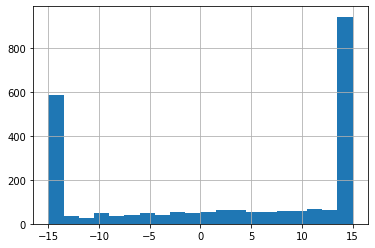

In [89]:
log = dashapp.logging.getLogger(__name__)
log.setLevel(dashapp.logging.INFO)
df_es99['5day'].hist(bins=20)

In [91]:
df_es99[df_es99['5day']>0]['5day'].mean(),df_es99[df_es99['5day']<0]['5day'].mean()

(12.001119352663522, -11.53258031088083)

In [95]:
sql = f"select settle_date, close  corn from {futtab} where symbol = 'ZCZ99'"
df_corn = pga.get_sql(sql)
sql = f"select settle_date, close  crude from {futtab} where symbol = 'CLZ99'"
df_crude = pga.get_sql(sql)

## END

In [105]:
df_cc = df_crude.merge(df_corn,how='inner',on='settle_date')
df_cc['crude_ret'] = df_cc.crude.pct_change(1)
df_cc['corn_ret'] = df_cc.corn.pct_change(1)

display.display(df_cc.iloc[-50:][['crude','corn']].corr())
display.display(df_cc.iloc[-50:][['crude_ret','corn_ret']].corr())


,crude,corn
crude,1.000000,0.175722
corn,0.175722,1.000000


,crude_ret,corn_ret
crude_ret,1.00000,0.37202
corn_ret,0.37202,1.00000


In [117]:
df_cc['rolling_ret_cor'] = df_cc.crude_ret.rolling(40).corr(df_cc.corn_ret)
iplot(dashapp.plotly_plot(df_in=df_cc[['settle_date','rolling_ret_cor']].iloc[40:],
                         x_column='settle_date',
                          plot_title="Rolling 40 Trading Day Returns Correlation ",
                         y_left_label='Correlation'))